In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
import cv2

In [2]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

In [3]:
# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

Optimization terminated successfully.
         Current function value: 1.272130
         Iterations: 81
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 0.218207
         Iterations: 50
         Function evaluations: 99


In [4]:
# adjust data by adding outlyers
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))

Optimization terminated successfully.
         Current function value: 8.249316
         Iterations: 80
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 21.700908
         Iterations: 52
         Function evaluations: 102


In [5]:
# sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho')

In [6]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

In [7]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 07 12:16:05 PM: Your problem has 5000 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 07 12:16:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 07 12:16:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 07 12:16:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 07 12:16:05 PM: Compiling problem (target solver=ECOS).
(CVXPY) Feb 07 12:16:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

/usr/local/anaconda3/envs/PhD_clone_env/lib/python3.7/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Feb 07 12:16:07 PM: Applying reduction ECOS
(CVXPY) Feb 07 12:16:08 PM: Finished problem compilation (took 2.502e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 07 12:16:08 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Feb 07 12:17:43 PM: Problem status: optimal
(CVXPY) Feb 07 12:17:43 PM: Optimal value: 3.813e+02
(CVXPY) Feb 07 12:17:43 PM: Compilation took 2.502e+00 seconds
(CVXPY) Feb 07 12:17:43 PM: Solver (including time spent in interface) took 9.556e+01 seconds


In [8]:
# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

In [9]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)



In [10]:
# read original image and downsize for speed
import os
import imageio
import PIL
import scipy.misc
import cv2

os.chdir('/aijjeh_odroid_sensors/aidd/data/interim/exp/L3_S4_B/compressed/389286p_na_512x512p/')
Xorig = cv2.imread('frame_100_389286p_na_512x512p.png', 0) # read in grayscale
Xorig = np.asarray(Xorig)
X = spimg.zoom(Xorig, 0.25)
ny,nx = X.shape
print(ny, nx)

128 128


In [16]:
# extract small sample of signal
k = round(nx * ny * 0.0625) # 50% sample
print(k)
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
print(ri)
b = X.T.flat[ri]
b = np.expand_dims(b, axis=1)
print(b.shape)
b = np.squeeze(b, axis=-1)
print(b.shape)

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron
print(A.shape)
# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
print(constraints)
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

1024
[10331  8936 10063 ...  5004  5684 12867]
(1024, 1)
(1024,)
(1024, 16384)
[Equality(Expression(AFFINE, UNKNOWN, (1024,)), Constant(CONSTANT, NONNEGATIVE, (1024,)))]
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 07 01:01:33 PM: Your problem has 16384 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 07 01:01:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 07 01:01:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 07 01:01:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-----------------------------------------------------------------------

/usr/local/anaconda3/envs/PhD_clone_env/lib/python3.7/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Feb 07 01:01:44 PM: Applying reduction ECOS
(CVXPY) Feb 07 01:01:52 PM: Finished problem compilation (took 1.926e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 07 01:01:52 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Feb 07 01:11:46 PM: Problem status: optimal
(CVXPY) Feb 07 01:11:46 PM: Optimal value: 6.589e+04
(CVXPY) Feb 07 01:11:46 PM: Compilation took 1.926e+01 seconds
(CVXPY) Feb 07 01:11:46 PM: Solver (including time spent in interface) took 5.938e+02 seconds


In [17]:
def get_interpolated(parm):
    array = parm

    x = range(512)
    y = range(512)

    array = np.ma.masked_values(array, 0)
    print(array.shape)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]

    new_arr_ = array[~array.mask]
    x_new, y_new = np.linspace(0, 512, 512), np.linspace(0, 512, 512)
    xq, yq = np.meshgrid(x_new, y_new)

    GD1 = scipy.interpolate.griddata((x1, y1), new_arr_.ravel(), (xq, yq), method='cubic', fill_value=np.mean(new_arr_))
    finish = time.perf_counter()
     
    return GD1

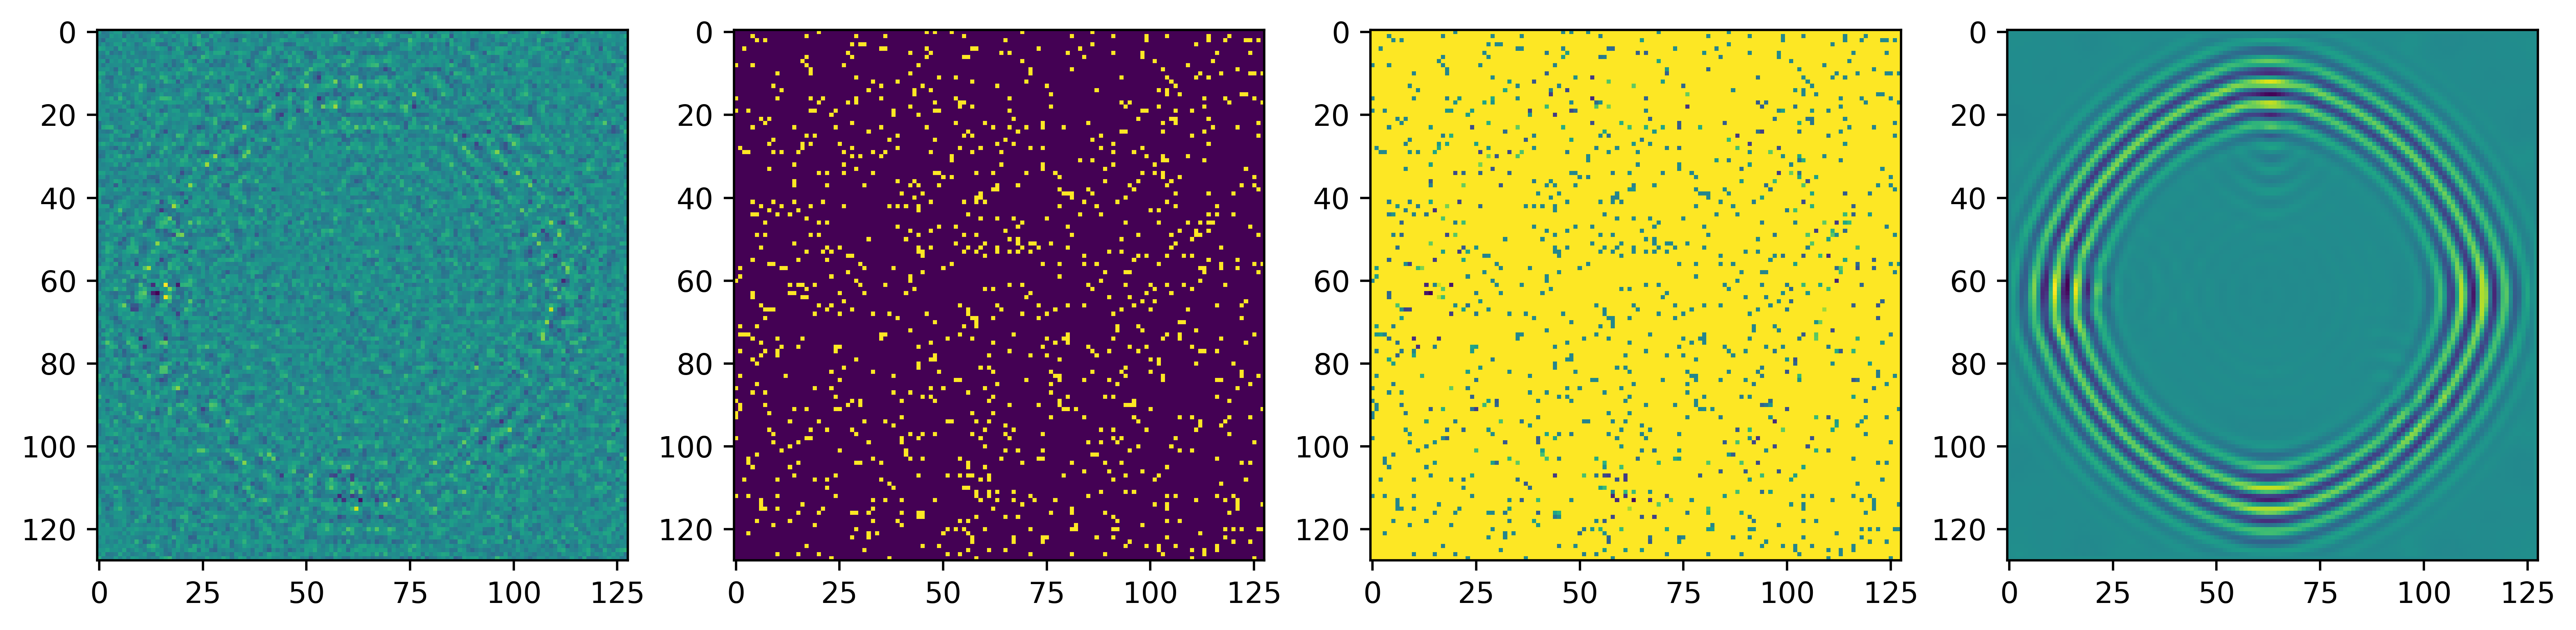

In [18]:
# reconstruct signal
import scipy.interpolate

Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

# confirm solution
if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
    print('Warning: values at sample indices don\'t match original.')

# create images of mask (for visualization)
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]

plt.figure(figsize=(15, 15), dpi=512)

ax1 = plt.subplot(1, 4, 1)
ax1.imshow(Xa)
# plt.axis('off')

ax2 = plt.subplot(1, 4, 2)
ax2.imshow(mask)
# plt.axis('off')

ax3 = plt.subplot(1, 4, 3)
ax3.imshow(Xm)
# plt.axis('off')

ax4 = plt.subplot(1, 4, 4)
ax4.imshow(X)
# plt.axis('off')



plt.show()




In [19]:
print(X.shape)
New_x = cv2.resize(X, (512,512), interpolation= cv2.INTER_CUBIC)

(128, 128)


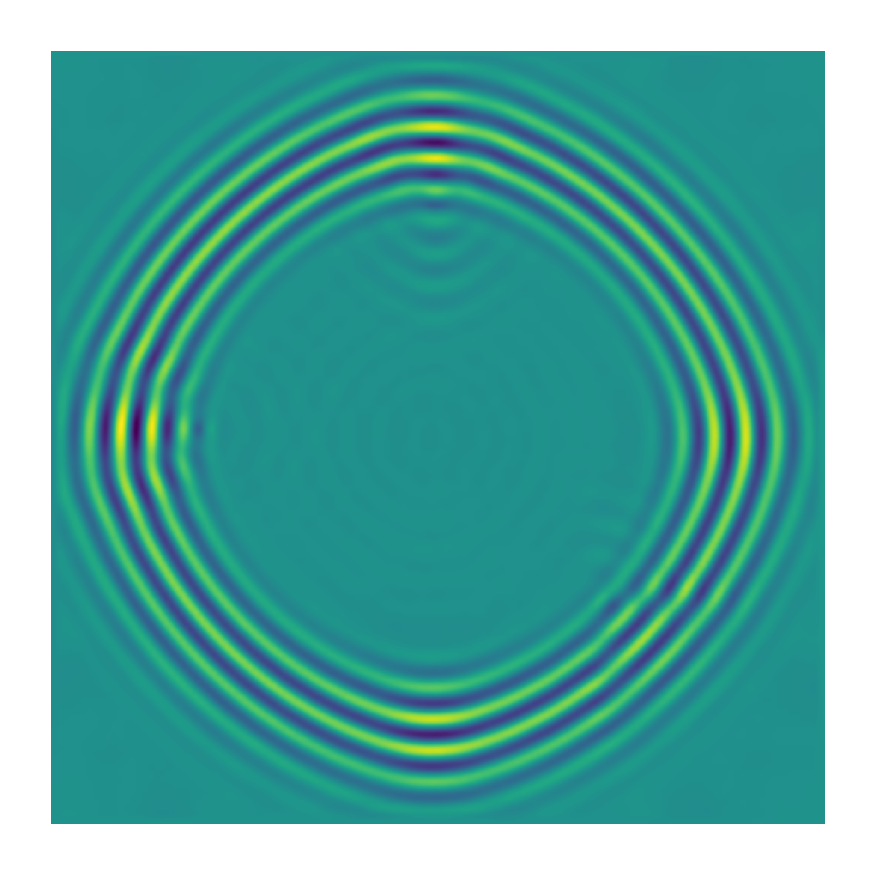

In [20]:
plt.figure(figsize=(2, 2), dpi=512)
plt.axis('off')
plt.imshow(New_x)
plt.show()

In [22]:
def normalize(y_true, y_pred):
    # cast the target images to integer
    y_true = y_true * 255.0
    y_true = y_true.astype(np.uint8)
    y_true = np.clip(y_true, 0, 255)
    
    # cast the predicted images to integer
    y_pred = y_pred * 255.0
    y_pred = y_pred.astype(np.uint8)
    y_pred = np.clip(y_pred, 0, 255)
    # return the psnr
    return y_true, y_pred

In [24]:
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [42]:
import math
Pearson_CC= []
PSNR = []

os.chdir('/aijjeh_odroid_sensors/aidd/data/interim/exp/L3_S4_B/compressed/389286p_na_512x512p/')
Xorig = cv2.imread('frame_100_389286p_na_512x512p.png', 0)  / 255.0
x_simple = np.asarray(Xorig)

y_simple = New_x

x_simple, y_simple = normalize(x_simple, y_simple)

my_rho = np.corrcoef(x_simple.flatten(), y_simple.flatten())
print('Pearson CC frame = ',my_rho[0][1])

temp_psnr = calculate_psnr(x_simple, y_simple)
print('PSNR frame = ', temp_psnr)

PSNR.append(temp_psnr)
Pearson_CC.append(my_rho[0][1])

Pearson CC frame =  -0.931310854374371
PSNR frame =  13.115545101029634


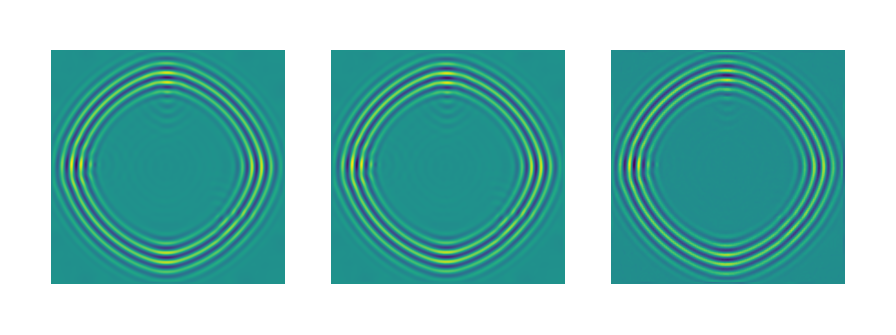

In [43]:
Xorig = Xorig*255
plt.figure(figsize=(2, 4), dpi=512)
ax1 = plt.subplot(1,3,1)
ax1.imshow(Xorig)
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
ax2.imshow(New_x)
ax2.axis('off')

diff = Xorig-New_x

ax3 = plt.subplot(1,3,3)
ax3.imshow(diff)
ax3.axis('off')
plt.show()



In [44]:
print(diff)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


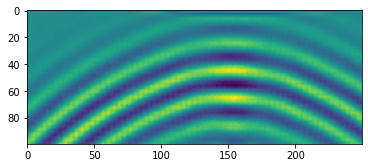

In [54]:
plt.imshow(diff[0:100, 100:350])
plt.show()

In [21]:
from pylbfgs import owlqn

def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx

# fractions of the scaled image to randomly sample at
sample_sizes = (0.1, 0.01)

# read original image
Xorig = spimg.imread('escher_waterfall.jpeg')
ny,nx,nchan = Xorig.shape

# for each sample size
Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
for i,s in enumerate(sample_sizes):

    # create random sampling index vector
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices

    # for each color channel
    for j in range(nchan):

        # extract channel
        X = Xorig[:,:,j].squeeze()

        # create images of mask (for visualization)
        Xm = 255 * np.ones(X.shape)
        Xm.T.flat[ri] = X.T.flat[ri]
        masks[i][:,:,j] = Xm

        # take random samples of image, store them in a vector b
        b = X.T.flat[ri].astype(float)

        # perform the L1 minimization in memory
        Xat2 = owlqn(nx*ny, evaluate, None, 5)

        # transform the output back into the spatial domain
        Xat = Xat2.reshape(nx, ny).T # stack columns
        Xa = idct2(Xat)
        Z[i][:,:,j] = Xa.astype('uint8')

ModuleNotFoundError: No module named 'pylbfgs'